# Devoir n° 2



Définition d'une classe abstraite de base pour toutes
couches que vous développerez.

In [76]:
import numpy as np
from matplotlib import pyplot as plt


class Couche:
    def __call__(self, *args):
        return self.forward(*args)

    def forward(self, *args):
        pass

    def backward(self, grad=None):
        pass

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

Tout au long de ce devoir, veillez vous assurez que les vecteurs aient la taille `(1, N)` ou `(N, 1)` plutôt que `(N,)`.</br>
Aussi lorsque vous faites une opération de réduction (somme, moyenne, etc...) sur un tenseur de taille `(M,N)`,
</br>assurez vous que la taille du résultat est `(1, N)` ou `(M, 1)` selon la dimension
choisie et non `(N,)` ou `(M,)`.

Exécutez la cellule ci-dessous pour en voir un exemple.


In [77]:
a = np.arange(60).reshape(4,5,3)
b = a.sum(axis=0, keepdims=True)
c = a.sum(axis=0)

print(b.shape, c.shape)

(1, 5, 3) (5, 3)


## Réseau de neurones à une couche

Veillez remplir les `...` par du code en vous inspirant du notebook du cours.




In [78]:
class Lineaire(Couche):
    def __init__(self,  dim_entree: int, dim_sortie:int):
        # compléter cette partie
        self.b = np.zeros(dim_sortie)
        self.W = np.random.randn(dim_entree, dim_sortie) * np.sqrt(2 / dim_entree)
        self.W_grad = np.zeros_like(self.W)
        self.b_grad = np.zeros_like(self.b)

    def forward(self, entree):
        self.entree = entree
        # compléter cette partie
        sortie = sortie = np.dot(entree, self.W) + self.b
        return sortie

    def backward(self, grad):
        # compléter cette partie
        self.entree_grad = np.dot(grad, self.W.T)
        self.W_grad += np.dot(self.entree.T, grad)
        self.b_grad += np.sum(grad, axis=0)
        return self.entree_grad

    def update(self, lr):
        # compléter cette partie
        self.W = self.W - lr * self.W_grad
        self.b = self.b - lr * self.b_grad

    def zero_grad(self):
        self.W_grad.fill(0)
        self.b_grad.fill(0)

In [79]:
# Exécuter cette cellule ne doit produire aucune erreur
entree_ = np.array([1, -1])[None]
sortie_ = np.array([10])[None]
# Définir un modèle d'une couche liant les entrée et sortie définies
model = Lineaire(2, 1)
sortie_predite = model(entree_)
assert sortie_predite.shape == sortie_.shape
print(sortie_predite)

[[-0.54718895]]


### Log Cosh Loss

La fonction cosinus hyperbolique  se définit par:
$x\in \mathbb{R}^N$

$$LogCosh(x) =  log(cosh(x))$$
$$LogCosh(x) =  log(\frac{e^x + e^{-x}}{2})$$

Avec $x = y_{prédit} - y_{réel}$

Dérivation:

$$
(log(cosh(x)))' = \frac{cosh'(x)}{cosh(x)}  
                = \frac{sinh(x)}{cosh(x)} 
                = tanh(x)  
%                    = \frac{e^x(1 - e^{-2x})^2}{2(1 + e^{-2x})}  
$$

In [80]:
class LogCoshLoss(Couche):
    def forward(self, sortie_reelle, sortie_predite):
        self.sortie_reelle = sortie_reelle
        self.sortie_predite = sortie_predite
        x = sortie_predite - sortie_reelle
        perte = np.log(np.cosh(x)).mean()
        return perte

    def backward(self, grad=None):
        x = self.sortie_predite - self.sortie_reelle
        grad_loss = np.tanh(x)
        if grad is not None:
            grad_loss *= grad
        return grad_loss


In [81]:
# Compléter la fonction ci-dessous pour faire un entraînement
# sur le nombre d'époques spécifiées, suivant le rythme lr et
# l'ensemble des paramètres spécifiés
def fit(model, entrees, sorties, loss_func, epoques, lr):
    for i in range(epoques):
        sortie_predites = model(entrees)
        lossvalue = loss_func.forward(sorties, sortie_predites)
        print(f'Epoque #{i}  loss: {lossvalue} ')
        sortie_predites_grad = loss_func.backward()
        model.backward(sortie_predites_grad)
        model.update(lr)
        model.zero_grad()
    #assert (np.abs(sortie_predites - sorties) < 1e-5).all()
    print(f'prediction:{sortie_predites[0,0]}\t cible:{sorties[0,0]}')

In [82]:
# Exécuter cette cellule ne doit produire aucune erreur


epoques = 10
lr = 0.2

entree_ = np.array([1, -1, 0.5, 4])[None]
sortie_ = np.array([10, 3])[None]
loss = LogCoshLoss()
# Définir un modèle d'une couche liant les entrée et sortie définies
model = Lineaire(4, 2)

fit(model, entree_, sortie_, loss, epoques, lr)

Epoque #0  loss: 6.4491870715336335 
Epoque #1  loss: 2.6017636054866022 
Epoque #2  loss: 0.2724786069215438 
Epoque #3  loss: 0.6680071458115844 
Epoque #4  loss: 0.5871255642521017 
Epoque #5  loss: 0.9421967304732841 
Epoque #6  loss: 1.2311837825258496 
Epoque #7  loss: 1.1115777948751933 
Epoque #8  loss: 1.1880010441630713 
Epoque #9  loss: 1.14244833231094 
prediction:11.780173847966363	 cible:10


## L'activation softplus 

Il existe plusieurs fonctions d'activation parmi lesquelles
compte la fonction softplus
qui est dérivable en zéro contrairement à la fonction RELU définie par:


$softplus(x) = log(1+e^x)$

Si $ \begin{align}
    x &= \begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{n}
         \end{bmatrix}
  \end{align}$, alors
$ \begin{align}
    f(x) &= \begin{bmatrix}
           f(x_{1}) \\
           f(x_{2}) \\
           \vdots \\
           f(x_{n})
         \end{bmatrix}
  \end{align}
\text{ pour } f \text{ une fonction d'activation}
$

Dérivation :

$$softplus'(x) = \sigma(x) = \frac{1}{1+e^{-x}}$$


#### Tracer les courbes des fonctions softplus et RELU sur l'intervalle [-20,20] afin de voir les similarités et différences:

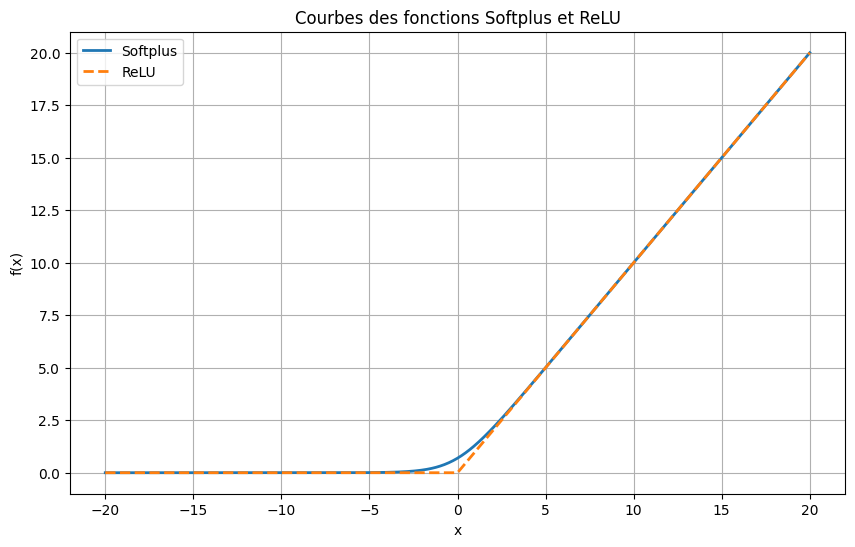

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des fonctions d'activation
def softplus(x):
    return np.log(1 + np.exp(x))

def relu(x):
    return np.maximum(0, x)

# Définition de l'intervalle
x_values = np.linspace(-20, 20, 1000)

# Calcul des valeurs des fonctions pour chaque point de l'intervalle
softplus_values = softplus(x_values)
relu_values = relu(x_values)

# Tracé des courbes
plt.figure(figsize=(10, 6))

plt.plot(x_values, softplus_values, label='Softplus', linewidth=2)
plt.plot(x_values, relu_values, label='ReLU', linewidth=2, linestyle='--')

# Ajout de titres et de légendes
plt.title('Courbes des fonctions Softplus et ReLU')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# Affichage du graphe
plt.grid(True)
plt.show()


In [84]:
# Compléter le code ci-dessous pour l'activation softplus.
class Softplus(Couche):
    def forward(self, entree_):
        self.entree_ = entree_
        # compléter cette partie
        self.sortie_ = np.log(1 + np.exp(entree_))
        return self.sortie_
    
    def backward(self, sortie_grad):
        # compléter cette partie
        
        # gradient softplus
        self.grad = 1 / (1 + np.exp(-self.entree_))
        # gradient relativement au loss
        self.entree_grad = self.grad * sortie_grad 
        return self.entree_grad

#### Test de l'activation softplus

Aucune erreur ne doit se produire en exécutant la cellule ci-dessous.

In [85]:
softplus = Softplus()
entree_ = np.expand_dims(np.array([1, 0.5, 0, -0.5, -1]), 0)
sortie_ = softplus(entree_) 
assert sortie_.shape == entree_.shape, 'Erreur, dimensions non conservée'
assert (sortie_ != entree_).all(), 'Erreur, entrée égale à la sortie'
assert (sortie_ > 0).all(), 'Erreur, sortie ayant des valeurs ≤ 0'
softplus.backward(entree_)
print(f'Gradient calculée:\n {softplus.grad.T}', '\n')
h=1e-6
approx_grad = (softplus(entree_+h) - softplus(entree_-h))/(2*h)
print(f'Gradient approximatif:\n {approx_grad.T}', '\n')
print(f'Différence entre Gradients calculé et approximatif:\n {(softplus.grad - approx_grad).T}')
assert (np.abs(softplus.grad - approx_grad) < h).all()

Gradient calculée:
 [[0.73105858]
 [0.62245933]
 [0.5       ]
 [0.37754067]
 [0.26894142]] 

Gradient approximatif:
 [[0.73105858]
 [0.62245933]
 [0.5       ]
 [0.37754067]
 [0.26894142]] 

Différence entre Gradients calculé et approximatif:
 [[ 6.75225431e-11]
 [ 1.19816379e-11]
 [-6.98889835e-11]
 [ 1.47738488e-11]
 [ 4.24996704e-11]]


# Perceptron Multicouche

Le but de cette partie est de mettre en place un réseau Perceptron multicouche de profondeur arbitraire !

In [86]:
from typing import List

class MLP(Couche):
    def __init__(self, couches: List[Couche]):
        self.couches = couches

    def forward(self, entree):
        sortie = entree
        for couche in self.couches:
            sortie = couche.forward(sortie)
        return sortie

    def backward(self, loss_grad):
        sortie_grad = loss_grad
        for couche in reversed(self.couches):
            sortie_grad = couche.backward(sortie_grad)
        return sortie_grad

    def update(self, lr):
        # compléter cette partie
        for couche in self.couches:
            couche.update(lr)

    def zero_grad(self):
        # compléter cette partie
        for couche in self.couches:
            couche.zero_grad()

In [87]:
# Exécuter cette cellule ne doit produire aucune erreur
epoques = 20
lr = 0.2
loss = LogCoshLoss()
entree_ = np.array([1, -1, 2.])[None]
sortie_ = np.array([10])[None]
# Écrire un modèle MLP dont les nombres de neurones
# par couche sont: 4 --> 3 --> 2 --> 1 et la dernière couche est sans activation.
# 
model = MLP([
    Lineaire(dim_entree=3, dim_sortie=2),
    Softplus(),                            # Activation Softplus
    Lineaire(dim_entree=2, dim_sortie=1),

])

fit(model, entree_, sortie_, loss, epoques, lr)

Epoque #0  loss: 10.062931451633823 
Epoque #1  loss: 9.527449830158243 
Epoque #2  loss: 9.17133607735637 
Epoque #3  loss: 8.87912318158622 
Epoque #4  loss: 8.615425378896893 
Epoque #5  loss: 8.365662128652863 
Epoque #6  loss: 8.122251058387857 
Epoque #7  loss: 7.88013551236858 
Epoque #8  loss: 7.634749583538305 
Epoque #9  loss: 7.3804554477966136 
Epoque #10  loss: 7.108338427762931 
Epoque #11  loss: 6.801663603156275 
Epoque #12  loss: 6.424685654724954 
Epoque #13  loss: 5.892287508686808 
Epoque #14  loss: 4.984986245882565 
Epoque #15  loss: 3.1307344369091434 
Epoque #16  loss: 0.06380480441517127 
Epoque #17  loss: 1.375626744211521 
Epoque #18  loss: 3.459005221167944 
Epoque #19  loss: 3.663445874637651 
prediction:5.64357138897112	 cible:10


## Application au dataset MNIST

In [88]:
from torchvision.datasets import MNIST
from sklearn.model_selection import StratifiedShuffleSplit

mnist = MNIST('./', download=True)

(x, y) = (mnist.train_data.numpy(), mnist.train_labels.numpy())
sss = StratifiedShuffleSplit(n_splits=3, test_size=1./3., random_state=10)
idxs = sss.split(x, y)
i=0
for train_idxs, test_idxs in idxs:
    (x_train, y_train) = (x[train_idxs], y[train_idxs])
    (x_test, y_test) =   (x[test_idxs], y[test_idxs])
    break

x_train, x_test = x_train / 255.0, x_test / 255.0


c:\Users\COULIBALYPEKANRIKADI\cpkv\ECOLE\INP\M2\MOI\DEEP LEARNING\PROJET2\.venv\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\COULIBALYPEKANRIKADI\cpkv\ECOLE\INP\M2\MOI\DEEP LEARNING\PROJET2\.venv\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [89]:
print("x shape is", x_train.shape)
print("y shape is", y_train.shape)

x shape is (40000, 28, 28)
y shape is (40000,)


In [90]:
print("x shape is", x_test.shape)
print("y shape is", y_test.shape)

x shape is (20000, 28, 28)
y shape is (20000,)


[5 5 0 1 6 2 5 2 6]


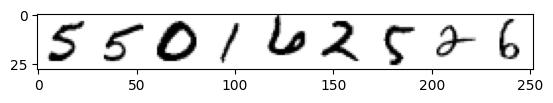

In [91]:
import matplotlib.pyplot as plt

def plot_image(array):
    plt.imshow(array, cmap='gray_r')

plot_image(np.hstack(x_train[1:10]))
print(y_train[1:10])

In [92]:
from time import time
# Compléter cette fonction pour l'entraînement par lot de données
def fit_batch(model, x, y, bs, loss_func, epoques, lr):
    """
    bs: taille du lot ou batch de données
    """
    entrees = x.copy()
    sorties = y.copy()
    all_losses = []
    N = entrees.shape[0]
    t = time()
    for i in range(epoques):
        losses = []
        # Re-agencement aléatoire des données
        shuffle = np.random.permutation(N)
        entrees = entrees[shuffle]
        sorties = sorties[shuffle]
        for k in range(0, N, bs):
            sorties_predites = model(entrees[k:k+bs])
            lossvalue = loss_func(sorties[k:k+bs], sorties_predites)
            losses.append(lossvalue)
            sortie_predite_grad = loss_func.backward()
            model.backward(sortie_predite_grad)
            model.update(lr)
            model.zero_grad()
        all_losses += losses
        if i%10 == 0:
            print(f'Epoque #{i}\tloss: {round(np.mean(losses), 3)}\ttime: {round(time() - t, 3)} ')
            t = time()
            
    return all_losses

## Modèles Regressifs

In [93]:
# Exécuter cette cellule ne doit produire aucune erreur


# Convertis les images en vecteurs
entrees = x_train.reshape((-1, 28*28))
sorties = y_train.reshape((-1,1))
# Écrire un modèle MLP dont les nombres de neurones
# par couche sont: 784 --> 50 --> 1 et la dernière couche est sans activation.
# 
model = MLP([Lineaire(784, 50), Softplus(), Lineaire(50, 1)])
bs=100
loss_func = LogCoshLoss()
epoques=100
lr=0.01
losses = fit_batch(model, entrees, sorties, bs, loss_func, epoques, lr)

Epoque #0	loss: 1.935	time: 1.45 
Epoque #10	loss: 1.888	time: 18.635 
Epoque #20	loss: 1.873	time: 18.942 
Epoque #30	loss: 1.909	time: 20.532 
Epoque #40	loss: 1.902	time: 17.565 
Epoque #50	loss: 1.908	time: 19.02 
Epoque #60	loss: 1.909	time: 17.709 
Epoque #70	loss: 1.855	time: 17.652 
Epoque #80	loss: 1.908	time: 17.017 
Epoque #90	loss: 1.908	time: 17.614 


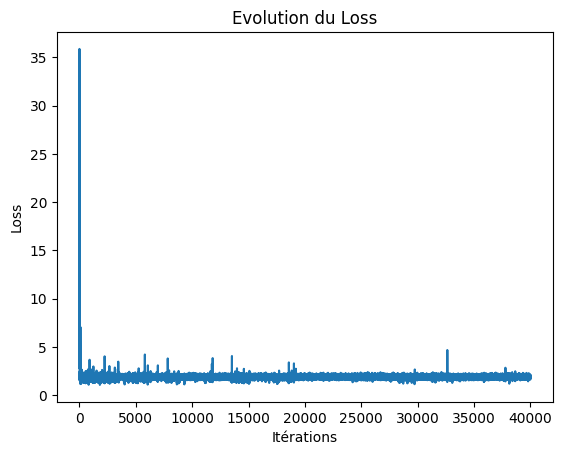

In [94]:
def plot_loss(losses):
    # Écrire le code pour afficher l'évolution du loss
    # en fonction des itérations(batch)
    plt.plot(losses)
    plt.xlabel('Itérations')
    plt.ylabel('Loss')
    plt.title('Evolution du Loss')
    plt.show()
    pass
losses = np.array(losses).reshape(-1)
plot_loss(losses)

### Evaluation du modèle régressif sur les données de test

In [95]:
# Compléter le code pour évaluer le modèle
def mesure_performance(model, xt, yt):
    # arrondir la prédiction à l'entier le plus proche.
    y_predit = np.round(model(xt))
    return np.mean(y_predit == yt)


xt = x_test.reshape((-1, 28*28))
yt = y_test.reshape((-1,1))
accuracy_simple = mesure_performance(model, xt, yt)
print(f'Performance du modèle profond : {accuracy_simple}')

Performance du modèle profond : 0.09735


### En profondeur

Écrire un modèle MLP `model_profond` dont les nombres de neurones
par couche sont: `784 --> 50 --> 10 --> 1` et la dernière couche est sans activation.

Entraîner ce modèle,l'Évaluer et le comparer au modèle précédent. Quel est le meilleur? Justifier votre réponse


In [96]:

# Exécuter cette cellule ne doit produire aucune erreur

# Convertis les images en vecteurs
entrees = x_train.reshape((-1, 28*28))
sorties = y_train.reshape((-1,1))

# Écrire un modèle MLP dont les nombres de neurones

model_profond = MLP([
    Lineaire(dim_entree=784, dim_sortie=50),
    Softplus(),
    Lineaire(dim_entree=50, dim_sortie=10),
    Softplus(),
    Lineaire(dim_entree=10, dim_sortie=1)  # Correction ici
])
losses = fit_batch(model_profond, entrees, sorties, 100, LogCoshLoss(), 100, 0.01)

Epoque #0	loss: 1.431	time: 1.513 
Epoque #10	loss: 0.598	time: 16.912 
Epoque #20	loss: 0.49	time: 18.691 
Epoque #30	loss: 0.471	time: 16.451 
Epoque #40	loss: 0.45	time: 18.325 
Epoque #50	loss: 0.437	time: 16.051 
Epoque #60	loss: 0.43	time: 17.032 
Epoque #70	loss: 0.432	time: 23.197 
Epoque #80	loss: 0.421	time: 16.935 
Epoque #90	loss: 0.421	time: 19.264 


In [97]:
accuracy_profond = mesure_performance(model_profond, xt, yt)
print(f'Performance du modèle profond : {accuracy_profond}')

Performance du modèle profond : 0.33445


In [98]:
import torch
torch.cosh(torch.tensor(-1)).log()

tensor(0.4338)

## Passons à PyTorch
Tous les entraînements qui suivront se feront sur 100 époques avec la même architecture:

784 --> 50 --> 10 --> 1 ou 10

Pour la dernière couche, 1 est utilisé pour la régression et 10 pour la crossentropy et le loss de ciszar définie plus bas.

### 1. Entraîner de nouveau le modèle précédent (même architecture) avec PyTorch et la fonction de loss MSE.</br>Réaliser les mêmes évaluations. Comparer les résultats au précédent.

Epoque [1/100], Loss: 30.7478
Epoque [11/100], Loss: 22.1022
Epoque [21/100], Loss: 12.3733
Epoque [31/100], Loss: 10.0887
Epoque [41/100], Loss: 8.3023
Epoque [51/100], Loss: 7.1348
Epoque [61/100], Loss: 6.1266
Epoque [71/100], Loss: 5.4830
Epoque [81/100], Loss: 5.0724
Epoque [91/100], Loss: 4.8492


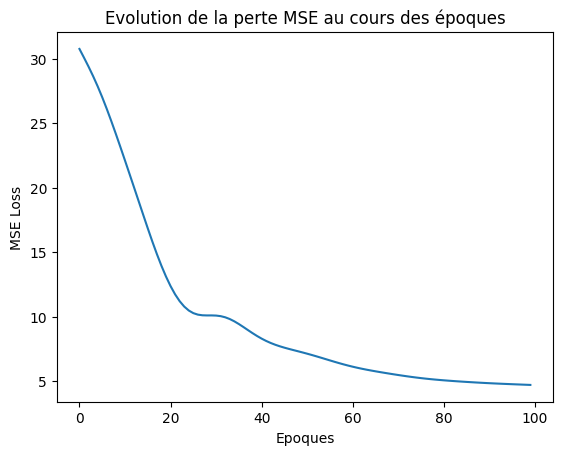

Test Loss: 4.7451
Accuracy: 17.19%


In [99]:
import torch
from torch import nn, optim

# Définir le modèle MLP avec PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 50)  # Couche 1 : 784 -> 50
        self.fc2 = nn.Linear(50, 10)   # Couche 2 : 50 -> 10
        self.fc3 = nn.Linear(10, 1)    # Couche 3 : 10 -> 1 (pour régression)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation ReLU
        x = torch.relu(self.fc2(x))  # Activation ReLU
        x = self.fc3(x)              # Pas d'activation pour la dernière couche
        return x

# Préparation des données
x_train_tensor = torch.tensor(x_train.reshape((-1, 28*28)), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape((-1, 1)), dtype=torch.float32)

# Initialisation du modèle, fonction de perte (MSE) et optimiseur
model = MLP()
criterion = nn.MSELoss()   # Fonction de perte : Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.001)


epoques = 100
mseloss = []  # Liste pour sauvegarder les valeurs du loss à chaque époque

for epoch in range(epoques):
    model.train()

    # Forward pass
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass et optimisation
    optimizer.zero_grad()  # Mise à zéro des gradients
    loss.backward()        # Calcul des gradients
    optimizer.step()       # Mise à jour des paramètres

    # Sauvegarde de la valeur de la perte pour cette époque
    mseloss.append(loss.item())

    # Affichage du progrès
    if epoch % 10 == 0:
        print(f'Epoque [{epoch+1}/{epoques}], Loss: {loss.item():.4f}')

plt.plot(mseloss)
plt.xlabel('Epoques')
plt.ylabel('MSE Loss')
plt.title('Evolution de la perte MSE au cours des époques')
plt.show()

# Évaluation sur les données de test
x_test_tensor = torch.tensor(x_test.reshape((-1, 28*28)), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape((-1, 1)), dtype=torch.float32)

model.eval()  # Met le modèle en mode évaluation
with torch.no_grad():  # Pas de calcul de gradients pour l'évaluation
    y_test_pred = model(x_test_tensor)
    test_loss_MSE = criterion(y_test_pred, y_test_tensor)
    print(f'Test Loss: {test_loss_MSE.item():.4f}')
    accuracy = torch.mean((torch.round(y_test_pred) == y_test_tensor).float())
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')




In [100]:
accuracy_torch = accuracy.item()
print(f'Performance du modèle avec PyTorch : {accuracy_torch:.4f}')

Performance du modèle avec PyTorch : 0.1719


### 2. Entraîner le même réseau avec la fonction de loss nommée `crossentropy` en ajoutant le softmax à la suite de la dernière couche.</br> Réaliser les mêmes évaluations et enregistrer les valeurs du loss. Comparer le résultat au précédent. Quel est le meilleur? Que peut-on dire de l'impact du choix de la fonction de loss dans l'entraînement d'un modèle

In [135]:
x_train_tensor = torch.tensor(x_train.reshape(-1, 784), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

x_test_tensor = torch.tensor(x_test.reshape(-1, 784), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Création du modèle, de la fonction de perte et de l'optimiseur
model1 = MLP()
criterion = nn.MSELoss()  # Mean Squared Error loss pour la régression
optimizer = optim.Adam(model1.parameters(), lr=0.01)

# Entraînement du modèle pendant 100 époques
epochs = 100
crossentropy_loss = []  # Liste pour stocker les pertes de chaque époque

for epoch in range(epochs):
    model1.train()
    optimizer.zero_grad()
    output = model1(x_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    crossentropy_loss.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Époque {epoch+1}/{epochs}, Loss: {loss.item()}')

Époque 10/100, Loss: 7.1548686027526855
Époque 20/100, Loss: 5.335663318634033
Époque 30/100, Loss: 4.507032871246338
Époque 40/100, Loss: 4.190762996673584
Époque 50/100, Loss: 3.931489944458008
Époque 60/100, Loss: 3.7559690475463867
Époque 70/100, Loss: 3.640887498855591
Époque 80/100, Loss: 3.548206329345703
Époque 90/100, Loss: 3.471111297607422
Époque 100/100, Loss: 3.3970398902893066


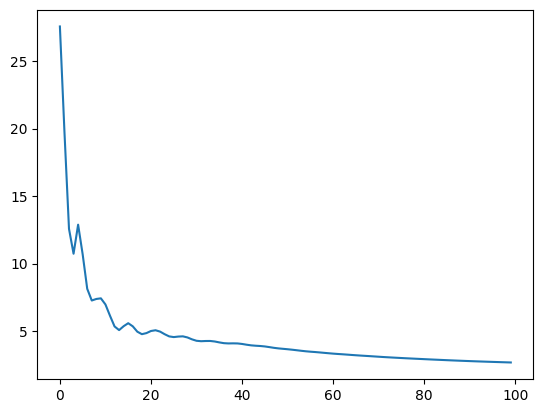

In [136]:
import matplotlib.pyplot as plt
plt.plot(mseloss)


In [137]:
def mesure_perf_pyTorch(model, xt, yt):
    xt = torch.tensor(xt, dtype=torch.float)
    yt = torch.tensor(yt, dtype=torch.long).squeeze()
    yp = model(xt)
    return (yt.float() == torch.argmax(yp, dim=1).reshape((-1,1)).float()).float().mean()
mesure_perf_pyTorch(model1, xt, yt)

tensor(0.0988)

Le choix de la fonction de perte joue un rôle crucial dans l'entraînement d'un modèle, car elle détermine la manière dont le modèle ajuste ses paramètres pour réduire les erreurs.  

Dans le cadre d'une tâche de classification, le modèle entraîné avec la fonction de perte **Cross-Entropy** a obtenu les meilleurs résultats.
Cela s'explique par le fait que la **Cross-Entropy** est spécialement conçue pour les problèmes de classification multi-classe, en maximisant directement la probabilité de la classe correcte. En revanche, la **MSE**, en traitant les classes comme des valeurs continues, s'avère moins adaptée et moins performante dans ce type de contexte.  

### 3. Une autre fonction de loss: Divergence de Csízar

$$S(p,q) = \sum_{i=0}^{9} [\frac{(p_i+q_i)(p_i-q_i)^2}{p_iq_i}] \ln [\frac{p_i+q_i}{2\sqrt{p_iq_i}}]$$

Cette formule est le loss appliqué entre une prédiction ($q = y'$) et son résultat attendue ($p = y$) car nous
avons 10 catégories de chiffres dans la base MNIST.

Dans notre cas, $p = y$ et $q = y'$ où y est la prédiction et y est le résultat attendu.


In [125]:
def divergence_ciszar(ypred, ytrue):
    # Implémenter la formule en ajoutant un epsilon = 1e-10 à chaque
    # dénominateur pour éviter une division par zéro et supposant que
    # ypred et ytrue sont des PyTorch tensors

    epsilon = 1e-10  # Petite constante pour éviter les divisions par zéro et les logs de zéro

    # Vérification et clamping pour éviter les singularités
    ypred = ypred.clamp(min=epsilon)
    ytrue = ytrue.clamp(min=epsilon)

    # Calcul des termes
    sum_pq = ypred + ytrue
    diff_pq = ypred - ytrue
    product_pq = ypred * ytrue

    # Calcul des termes de la formule
    term1 = (sum_pq * (diff_pq ** 2)) / product_pq
    term2 = torch.log(sum_pq / (2 * torch.sqrt(product_pq)))

    # Résultat final : somme sur les classes (dim=-1), puis moyenne sur les batchs
    res = torch.sum(term1 * term2, dim=-1).mean()

    return res


Pour vous aider, vous pouvez tester la fonction sur les données suivantes.
`divergence_ciszar(y1, y1_prime)` doit donner une valeur scalaire de même son application à y_batch et y_prime_batch.

In [126]:
y1 = torch.tensor([0.004, 0.031, 0.109, 0.219, 0.274, 0.219, 0.109, 0.031, 0.004])
y1_prime = torch.tensor([0.005, 0.030, 0.104, 0.220, 0.282, 0.220, 0.104, 0.030, 0.005])

y2 = torch.tensor([0.017, 0.090, 0.209, 0.279, 0.232, 0.124, 0.041, 0.008, 0.001])
y2_prime = torch.tensor([0.020, 0.082, 0.198, 0.285, 0.244, 0.124, 0.037, 0.007, 0.0007])

y_batch = torch.stack([y1, y2])
y_prime_batch = torch.stack([y2, y2_prime])

In [127]:
y1.shape, y_batch.shape

(torch.Size([9]), torch.Size([2, 9]))

In [128]:
divergence_ciszar(y1, y1_prime)

tensor(5.9143e-06)

In [129]:
divergence_ciszar(y_batch, y_prime_batch)

tensor(0.0417)

Compléter le code du loss de Ciszar et l'utiliser en replacement de la crossentropy utilisée précédemment pour entraîner le modèle

In [130]:
class CiszarLoss(nn.Module):
    def __init__(self):
        super(CiszarLoss, self).__init__()

    def forward(self, outputs, targets):
        # Calculer le loss en utilisant la fonction divergence_ciszar
        loss = divergence_ciszar(outputs, targets)
        return loss

In [131]:
class MLPCiszar(nn.Module):
    def __init__(self):
        super(MLPCiszar, self).__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x



Epoque [1/100], Loss: 8960707584.0000
Epoque [11/100], Loss: 8639811584.0000
Epoque [21/100], Loss: 8340663808.0000
Epoque [31/100], Loss: 7939419648.0000
Epoque [41/100], Loss: 7540533760.0000
Epoque [51/100], Loss: 7151075328.0000
Epoque [61/100], Loss: 6750352896.0000
Epoque [71/100], Loss: 6312654848.0000
Epoque [81/100], Loss: 5783374848.0000
Epoque [91/100], Loss: 5275949568.0000


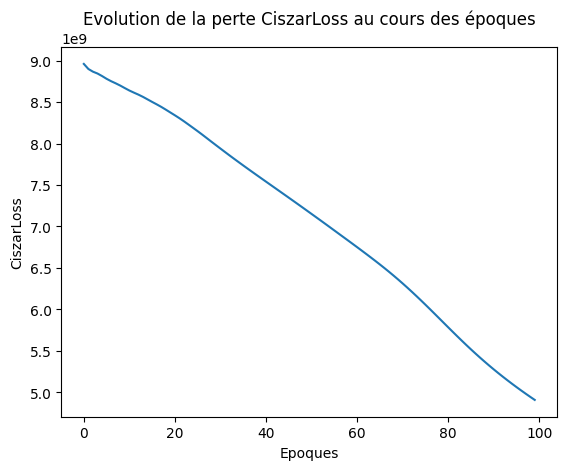

In [132]:
import torch.nn.functional as F
# Préparation des données
x_train_tensor = torch.tensor(x_train.reshape((-1, 28 * 28)), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Étiquettes sous forme d'entiers
y_train_onehot = F.one_hot(y_train_tensor, num_classes=10).float()  # Conversion en one-hot encoding

# Initialisation du modèle, fonction de perte (CiszarLoss) et optimiseur
model_ciszar = MLPCiszar()
criterion_ciszar = CiszarLoss()  # Fonction de perte : CiszarLoss
optimizer_ciszar = optim.Adam(model_ciszar.parameters(), lr=0.001)

# Entraînement
epoques = 100
ciszarloss = []  # Liste pour sauvegarder les valeurs du loss à chaque époque

for epoch in range(epoques):
    model_ciszar.train()

    # Forward pass
    y_pred = model_ciszar(x_train_tensor)
    loss = criterion_ciszar(y_pred, y_train_onehot)  # Calcul de la perte avec CiszarLoss

    # Backward pass et optimisation
    optimizer_ciszar.zero_grad()  # Mise à zéro des gradients
    loss.backward()               # Calcul des gradients
    optimizer_ciszar.step()       # Mise à jour des paramètres

    # Sauvegarde de la valeur de la perte pour cette époque
    ciszarloss.append(loss.item())

    # Affichage du progrès
    if epoch % 10 == 0:
        print(f'Epoque [{epoch+1}/{epoques}], Loss: {loss.item():.4f}')

plt.plot(ciszarloss)
plt.xlabel('Epoques')
plt.ylabel('CiszarLoss')
plt.title('Evolution de la perte CiszarLoss au cours des époques')
plt.show()

Afficher sur un même graphe, l'évolution des trois losses: mseloss, celoss and ciszarloss.
Commenter les vitesses de convergence des uns par rapport aux autres.

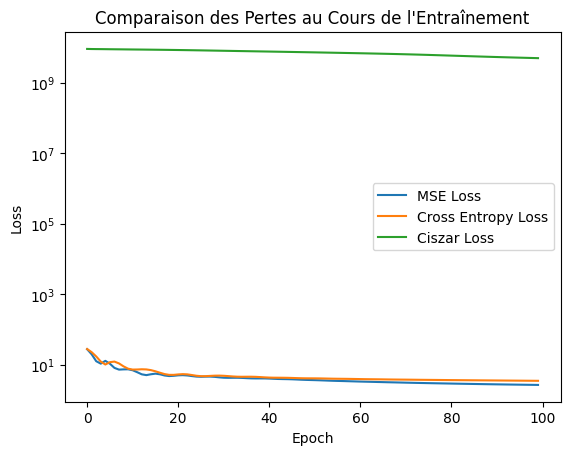

In [133]:
plt.plot(mseloss, label='MSE Loss')
plt.plot(crossentropy_loss, label='Cross Entropy Loss')
plt.plot(ciszarloss, label='Ciszar Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Graphique logarithmique pour comparer les échelles
plt.title('Comparaison des Pertes au Cours de l\'Entraînement')
plt.legend()
plt.show()

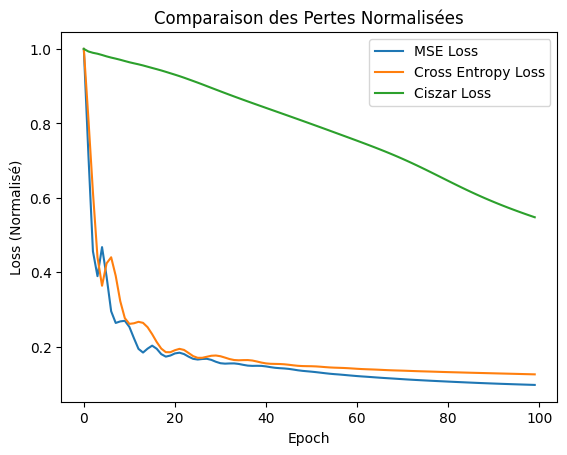

In [134]:
mseloss1 = [loss / max(mseloss) for loss in mseloss]
crossentropy_loss2 = [loss / max(crossentropy_loss) for loss in crossentropy_loss]
ciszarloss3 = [loss / max(ciszarloss) for loss in ciszarloss]

plt.plot(mseloss1, label='MSE Loss')
plt.plot(crossentropy_loss2, label='Cross Entropy Loss')
plt.plot(ciszarloss3, label='Ciszar Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Normalisé)')
plt.title('Comparaison des Pertes Normalisées')
plt.legend()
plt.show()

< commentaire >
**Erreur quadratique moyenne (MSE Loss)**  
- La MSE (Mean Squared Error) est particulièrement sensible aux grandes erreurs, car elle met au carré la différence entre les valeurs prédites et les valeurs réelles.  
- Cette sensibilité peut ralentir la convergence au début de l'entraînement, notamment lorsque les prédictions initiales sont éloignées des vraies valeurs.  
- Le modèle peut également avoir des difficultés à réduire rapidement les petites erreurs et à atteindre un minimum local efficacement.  
- En termes de vitesse de convergence, la MSE est généralement plus rapide que la **Ciszár Loss**, mais plus lente que la **Cross-Entropy Loss**.  

**Fonction de perte d'entropie croisée (Cross-Entropy Loss)**  
- La Cross-Entropy est particulièrement adaptée aux problèmes de classification, car elle fournit un signal d'erreur clair et direct sur la qualité des prédictions.  
- Elle favorise une descente plus rapide, ce qui est un atout pour des tâches comme la classification d'images (par exemple, MNIST).  
- Parmi les trois fonctions de perte mentionnées, la Cross-Entropy tend à converger le plus rapidement.  

**Divergence de Csízar (Ciszár Loss)**  
- La Ciszár Loss présente une convergence souvent moins stable et moins rapide par rapport à la Cross-Entropy.  
- Elle tend à converger plus lentement que les deux autres fonctions de perte, en particulier dans des contextes où une rétroaction rapide est essentielle pour ajuster les paramètres du modèle.  

**Félicitations !** </br>
Vous avez dorénavant une bonne compréhension de la lourde artillerie embarquée dans les frameworks de Deep Learning !